In [39]:
import time
import serial
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from scipy.fft import fft
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler



In [10]:
import glob
import os
import pandas as pd

# Procurar arquivos CSV no diretório especificado
csv_files = glob.glob('../data/*.csv')

# Normalizar os caminhos dos arquivos para usar barras '/'
csv_files = [os.path.normpath(file).replace('\\', '/') for file in csv_files]
for file in csv_files:
    print(file)
    

../data/bci_data_correto1.csv
../data/bci_data_correto10.csv
../data/bci_data_correto11.csv
../data/bci_data_correto12.csv
../data/bci_data_correto13.csv
../data/bci_data_correto14.csv
../data/bci_data_correto2.csv
../data/bci_data_correto3.csv
../data/bci_data_correto4.csv
../data/bci_data_correto5.csv
../data/bci_data_correto6.csv
../data/bci_data_correto7.csv
../data/bci_data_correto8.csv
../data/bci_data_correto9.csv


----

PROCESSAMENTO 2


In [34]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
from scipy.fftpack import fft
import pywt

# Parâmetros
window_size = 2952  # Número de amostras por janela
overlap = 0.57  # Sobreposição entre janelas
cutoff = 51  # Frequência de corte em Hz
frequencia_amostragem = 250  # Taxa de amostragem média em Hz (ajustada para EEG típico)
fixed_length = 348

X_features = []
y_labels = []
medicoes = 0

from scipy.interpolate import interp1d
def pad_or_interpolate(array, target_length):
    if len(array) < target_length:
        # Padding
        return np.pad(array, (0, target_length - len(array)), 'constant', constant_values=0)
    elif len(array) > target_length:
        # Interpolation
        x = np.arange(len(array))
        f = interp1d(x, array, kind='linear', fill_value='extrapolate')
        x_new = np.linspace(0, len(array)-1, target_length)
        return f(x_new)
    else:
        return array
    
# Filtro passa-baixa
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Função para calcular a potência nas bandas de frequência usando FFT
def band_power_fft(fft_values, freqs, band):
    # Filtra as frequências que estão dentro da banda desejada
    band_power = np.trapezoid(fft_values[(freqs >= band[0]) & (freqs <= band[1])], freqs[(freqs >= band[0]) & (freqs <= band[1])])
    return band_power

# Função para extrair features estatísticas
def extract_stat_features(data):
    mean = np.mean(data)
    variance = np.var(data)
    skewness = pd.Series(data).skew()
    kurtosis = pd.Series(data).kurtosis()
    return mean, variance, skewness, kurtosis

# Função para aplicar a transformada wavelet
def extract_wavelet_features(data, wavelet='db4'):
    coeffs = pywt.wavedec(data, wavelet)
    wavelet_features = []
    for coeff in coeffs:
        wavelet_features.extend([np.mean(coeff), np.var(coeff), np.min(coeff), np.max(coeff)])
    return wavelet_features

for file in csv_files:
    # Leitura do arquivo CSV
    data = pd.read_csv(file, sep=';')
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])
    data['VALUE'] = data['VALUE'] * (3.3 / 4098)

    print(f'Processando arquivo {file} | {data.shape[0]:,} amostras')
    medicoes += data.shape[0]

    # CRIAR JANELAS
    step_size = int(window_size * (1 - overlap))
    windows = []
    labels = []

    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        window = data.iloc[start:end]

        # Verificar se algum valor na janela tem CONCENTRATION = 1
        if window['CONCENTRATION'].any() == 1:
            labels.append(1)
        else:
            labels.append(0)

        windows.append(window)

    y_labels.extend(labels)

    # FILTRO EM TODAS JANELAS
    f_windows = []
    for i, window in enumerate(windows):
        timestamp = np.array(window['TIMESTAMP'])
        value = np.array(window['VALUE'])

        # Aplicar filtro passa-baixa
        filtered_value = butter_lowpass_filter(value, cutoff, frequencia_amostragem)
        filtered_window = pd.DataFrame({'TIMESTAMP': timestamp, 'VALUE': filtered_value})
        f_windows.append(filtered_window)

    # Extração de Features
    for window in f_windows:
        values = window['VALUE'].values - np.mean(window['VALUE'].values)

        # Taxa de amostragem
        timestamp_diff = window['TIMESTAMP'].diff().dt.total_seconds()
        sampling_rate = 1 / timestamp_diff[timestamp_diff > 0].mean()

        # FFT
        fft_values = np.abs(fft(values))[:len(values)//2]
        freqs = np.fft.fftfreq(len(values), d=1/sampling_rate)[:len(values)//2]
        fft_values_filtered = fft_values[freqs <= (cutoff + 5)]
        
        fft_values_filtered = pad_or_interpolate(fft_values_filtered, fixed_length)
        # print(f'Comprimento FFT Filtrada: {len(fft_values_filtered)}')

        # Potência nas bandas de frequência usando FFT
        delta_power = band_power_fft(fft_values, freqs, [0.5, 4])
        theta_power = band_power_fft(fft_values, freqs, [4, 8])
        alpha_power = band_power_fft(fft_values, freqs, [8, 13])
        beta_power = band_power_fft(fft_values, freqs, [13, 30])

        # Features estatísticas
        mean, variance, skewness, kurtosis = extract_stat_features(values)

        # Transformada Wavelet
        wavelet_features = extract_wavelet_features(values)

        # Combinar todas as features
        # features = list(fft_values) + [delta_power, theta_power, alpha_power, beta_power, mean, variance, skewness, kurtosis] + wavelet_features
        # features =  list(fft_values) + [delta_power, theta_power, alpha_power, beta_power] #MLP Classifier	0.757911	0.780645	0.640212	0.703488
        features =  list(fft_values) + list(wavelet_features)

        X_features.append(features)

# Conversão para arrays numpy
X_features = np.array(X_features)
y_labels = np.array(y_labels)

print(f'Total de medições: {medicoes:,}\n')
print('-----------------------------------')

print(f'Número total de janelas: {len(X_features)}')
print('-----------------------------------')

print(f'Número de janelas com CONCENTRATION = 1: {np.sum(y_labels)}')
print(f'Número de janelas com CONCENTRATION = 0: {len(y_labels) - np.sum(y_labels)}')


Processando arquivo ../data/bci_data_correto1.csv | 185,001 amostras
Processando arquivo ../data/bci_data_correto10.csv | 153,601 amostras
Processando arquivo ../data/bci_data_correto11.csv | 141,624 amostras
Processando arquivo ../data/bci_data_correto12.csv | 154,303 amostras
Processando arquivo ../data/bci_data_correto13.csv | 151,061 amostras
Processando arquivo ../data/bci_data_correto14.csv | 66,421 amostras
Processando arquivo ../data/bci_data_correto2.csv | 185,492 amostras
Processando arquivo ../data/bci_data_correto3.csv | 174,240 amostras
Processando arquivo ../data/bci_data_correto4.csv | 155,924 amostras
Processando arquivo ../data/bci_data_correto5.csv | 164,941 amostras
Processando arquivo ../data/bci_data_correto6.csv | 153,751 amostras
Processando arquivo ../data/bci_data_correto7.csv | 108,662 amostras
Processando arquivo ../data/bci_data_correto8.csv | 155,521 amostras
Processando arquivo ../data/bci_data_correto9.csv | 166,140 amostras
Total de medições: 2,116,682



TREINAMENTO

In [35]:
# # nomralize X_features
# scaler = StandardScaler()
# X_features = scaler.fit_transform(X_features)

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.3, random_state=74)

print(f"Tamanho treino: {X_train.shape}")
print(f"Tamanho teste: {X_test.shape}")

Tamanho treino: (1149, 1512)
Tamanho teste: (493, 1512)


	Classifier: LinearSVC
	Accuracy: 0.716024340770791
	Precision: 0.7729083665338645
	Recall: 0.7003610108303249
	F1-score: 0.7348484848484849


c:\Users\Paulo\OneDrive\Área de Trabalho\neuroTech\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



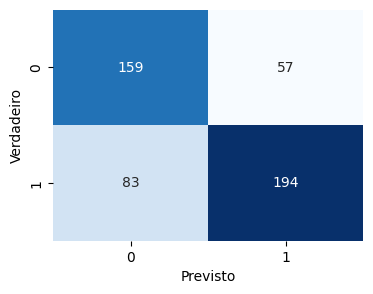

C:\Users\Paulo\AppData\Local\Temp\ipykernel_26668\4137450559.py:53: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.





	Classifier: Logistic Regression
	Accuracy: 0.7484787018255578
	Precision: 0.7886792452830189
	Recall: 0.7545126353790613
	F1-score: 0.7712177121771218


c:\Users\Paulo\OneDrive\Área de Trabalho\neuroTech\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



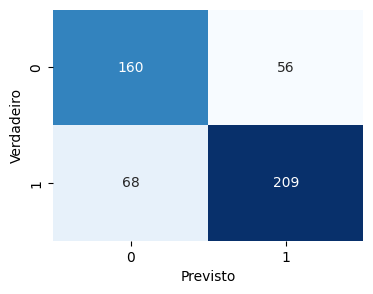



	Classifier: Random Forest
	Accuracy: 0.7464503042596349
	Precision: 0.7945736434108527
	Recall: 0.740072202166065
	F1-score: 0.7663551401869159


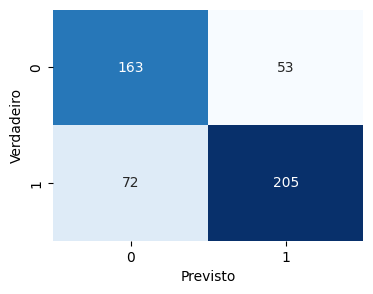



	Classifier: K-Nearest Neighbors
	Accuracy: 0.7018255578093306
	Precision: 0.7801724137931034
	Recall: 0.6534296028880866
	F1-score: 0.7111984282907662


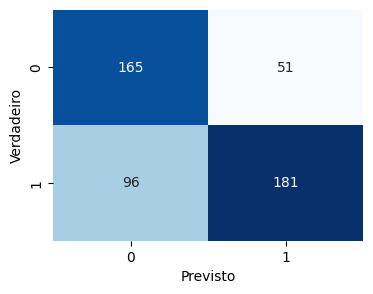



	Classifier: Gradient Boosting
	Accuracy: 0.7748478701825557
	Precision: 0.8051470588235294
	Recall: 0.7906137184115524
	F1-score: 0.7978142076502732


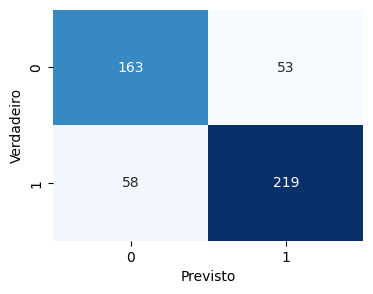



	Classifier: Decision Tree
	Accuracy: 0.6389452332657201
	Precision: 0.688212927756654
	Recall: 0.6534296028880866
	F1-score: 0.6703703703703704


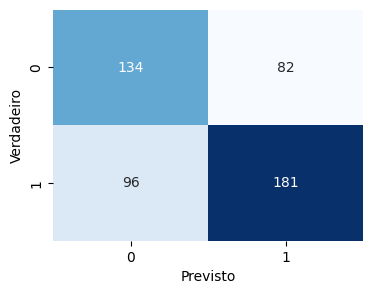



	Classifier: Gaussian Naive Bayes
	Accuracy: 0.6450304259634888
	Precision: 0.7771739130434783
	Recall: 0.516245487364621
	F1-score: 0.6203904555314533


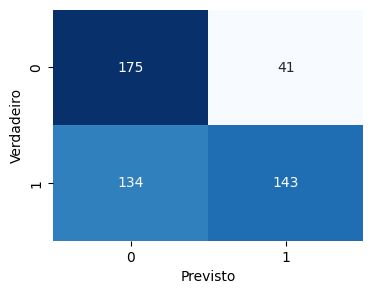



	Classifier: Support Vector Classifier
	Accuracy: 0.7667342799188641
	Precision: 0.813953488372093
	Recall: 0.7581227436823105
	F1-score: 0.7850467289719626


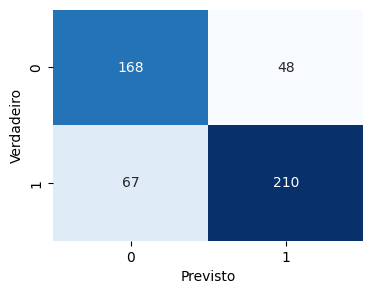

c:\Users\Paulo\OneDrive\Área de Trabalho\neuroTech\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



	Classifier: AdaBoost Classifier
	Accuracy: 0.7241379310344828
	Precision: 0.7660377358490567
	Recall: 0.7328519855595668
	F1-score: 0.7490774907749077


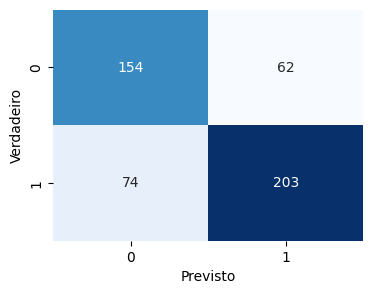



	Classifier: Linear Discriminant Analysis
	Accuracy: 0.5354969574036511
	Precision: 0.59375
	Recall: 0.5487364620938628
	F1-score: 0.5703564727954972


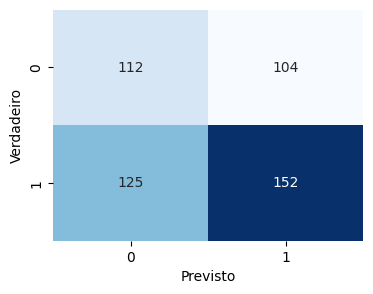



	Classifier: MLP Classifier
	Accuracy: 0.795131845841785
	Precision: 0.84375
	Recall: 0.779783393501805
	F1-score: 0.8105065666041276


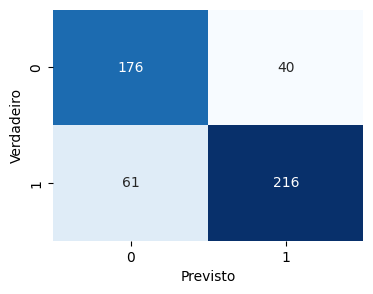

,Model,Accuracy,Precision,Recall,F1
10,MLP Classifier,0.795132,0.843750,0.779783,0.810507
4,Gradient Boosting,0.774848,0.805147,0.790614,0.797814
7,Support Vector Classifier,0.766734,0.813953,0.758123,0.785047
1,Logistic Regression,0.748479,0.788679,0.754513,0.771218
2,Random Forest,0.746450,0.794574,0.740072,0.766355
8,AdaBoost Classifier,0.724138,0.766038,0.732852,0.749077
0,LinearSVC,0.716024,0.772908,0.700361,0.734848
3,K-Nearest Neighbors,0.701826,0.780172,0.653430,0.711198
6,Gaussian Naive Bayes,0.645030,0.777174,0.516245,0.620390
5,Decision Tree,0.638945,0.688213,0.653430,0.670370


In [36]:
classifiers = {
    'LinearSVC': LinearSVC(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Support Vector Classifier': SVC(),
    'AdaBoost Classifier': AdaBoostClassifier(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'MLP Classifier': MLPClassifier(hidden_layer_sizes=(24, 8, 6, 4), max_iter=1000, early_stopping=True )
}


results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

# Loop sobre cada classificador
for name, clf in classifiers.items():
    # Treinar o classificador
    clf.fit(X_train, y_train)
    
    # Prever os rótulos do conjunto de teste
    y_pred = clf.predict(X_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Imprimir métricas
    print(f"\tClassifier: {name}")
    print(f"\tAccuracy: {accuracy}")
    print(f"\tPrecision: {precision}")
    print(f"\tRecall: {recall}")
    print(f"\tF1-score: {f1}")
    
    # Calcular a matriz de confusão
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Plotar a matriz de confusão
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.show()
    # plt.title(f'Matriz de confusão - {name}')

    print("\n")

    #create a dataframe with the results linke model name, accuracy, precision, recall and f1
    results = pd.concat([results, pd.DataFrame({'Model': [name], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1': [f1]})], ignore_index=True)

# print the results ordered by f1 score and accuracy
results = results.sort_values(by='Accuracy', ascending=False)
results


In [48]:
model = classifiers["MLP Classifier"]

import pickle

# Após treinar o modelo:
with open('MLP_without_fftFilter.pkl', 'wb') as f:
    pickle.dump(model, f)


In [61]:
import plotly.express as px

# Ordenar resultados por acurácia
results = results.sort_values(by='Recall', ascending=False)

# diminuir o tamanho do grafico
plt.figure(figsize=(3, 6))

# Plot com melhorias para storytelling
fig = px.line(results, 
              x='Model', 
              y='Recall', 
              title='Revocação dos Modelos de Classificação',
              labels={'Recall': 'Revocação (%)'},
              line_shape='spline',
              markers=True)

# Ajustes visuais
fig.update_traces(line=dict(color='purple', width=3), marker=dict(size=10, symbol='circle'))

# Adicionar anotações
best_model = results.iloc[0]
worst_model = results.iloc[-1]

fig.add_annotation(x=best_model['Model'], y=best_model['Recall'],
                   text=f"{best_model['Model']} <br>({best_model['Recall']:.2f}%)",
                   showarrow=False, arrowhead=1,
                   xshift=10,
                   yshift=25)

fig.add_annotation(x=worst_model['Model'], y=worst_model['Recall'],
                   text=f"{worst_model['Model']} <br>({worst_model['Recall']:.2f}%)",
                   showarrow=False, arrowhead=2,
                   xshift=40,
                   yshift=25)

fig.update_layout(
    width=900,  # Definir largura do plot
    height=400,  # Definir altura do plot
    xaxis=dict(tickangle=-45, showline=True, linewidth=2, linecolor='rgba(0, 0, 0, 0.5)', gridcolor='rgba(128, 128, 128, 0.3)'),
    yaxis=dict(showline=True, linewidth=2, linecolor='rgba(0, 0, 0, 0.5)', gridcolor='rgba(128, 128, 128, 0.3)'),
    plot_bgcolor='rgba(0,0,0,0)'
)

# Mostrar o plot
fig.show()


<Figure size 300x600 with 0 Axes>

In [44]:
with open('features.txt', 'r') as f:
    data_t = f.read()

# Assuming the features are separated by spaces or new lines, we can split and convert them into a DataFrame
features_list = data_t.split()
features_array = np.array(features_list, dtype=float).reshape(1, -1)
features_array

array([[ 4.50427251e-10,  6.02260820e+03,  1.31473525e+04, ...,
         1.38780111e+00, -4.33276932e+00,  4.04401086e+00]])

In [45]:

# Print the name and the prediction for all classifiers
for name, clf in classifiers.items():
    prediction = clf.predict(features_array)
    print(f"Classifier: {name}, Prediction: {prediction[0]}")


Classifier: LinearSVC, Prediction: 1
Classifier: Logistic Regression, Prediction: 1
Classifier: Random Forest, Prediction: 0
Classifier: K-Nearest Neighbors, Prediction: 1
Classifier: Gradient Boosting, Prediction: 1
Classifier: Decision Tree, Prediction: 1
Classifier: Gaussian Naive Bayes, Prediction: 0
Classifier: Support Vector Classifier, Prediction: 0
Classifier: AdaBoost Classifier, Prediction: 1
Classifier: Linear Discriminant Analysis, Prediction: 1
Classifier: MLP Classifier, Prediction: 1
